In [2]:
!pip install ncps
#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")



Mounted at /content/MyDrive


In [3]:
# @title Initialize Config

import torch
import numpy
class Config:
    def __init__(self, **kwargs):
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.target_transforms = kwargs.get('target_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection_v4/all_subjects_data_final.h5',
    dataset_root='/content/datasets',
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1','ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
)

#set seeds
torch.manual_seed(config.seed)
numpy.random.seed(config.seed)


#copy h5 over then change data_folder_Name
import shutil
shutil.copy('/content/MyDrive/MyDrive/sd_datacollection_v4/all_subjects_data_final.h5', '/content/all_subjects_data_final.h5')
config.data_folder_name = '/content/all_subjects_data_final.h5'

In [4]:
import os
import h5py
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.stats import pearsonr


class DataSharder:
    def __init__(self, config, split):
        self.config = config
        self.h5_file_path = config.data_folder_name  # Path to the HDF5 file
        self.split = split

    def load_data(self, subjects, window_length, forecast_horizon, dataset_name):
        print(f"Processing subjects: {subjects} with window length: {window_length}, forecast horizon: {forecast_horizon}")

        self.window_length = window_length
        self.forecast_horizon = forecast_horizon

        # Process the data from the HDF5 file
        self._process_and_save_patients_h5(subjects, dataset_name)

    def _process_and_save_patients_h5(self, subjects, dataset_name):
        # Open the HDF5 file
        with h5py.File(self.h5_file_path, 'r') as h5_file:
            dataset_folder = os.path.join(self.config.dataset_root, dataset_name, self.split).replace("subject", "").replace("__", "_")
            print("Dataset folder:", dataset_folder)

            if os.path.exists(dataset_folder):
                print("Dataset Exists, Skipping...")
                return

            os.makedirs(dataset_folder, exist_ok=True)
            print("Dataset folder created:", dataset_folder)

            for subject_id in tqdm(subjects, desc="Processing subjects"):
                if subject_id not in h5_file:
                    print(f"Subject {subject_id} not found in the HDF5 file. Skipping.")
                    continue

                subject_data = h5_file[subject_id]
                for session_id in subject_data.keys():
                    session_data_group = subject_data[session_id]
                    for session_speed in session_data_group.keys():
                        session_data = session_data_group[session_speed]

                        # Extract IMU, EMG, and Joint data as numpy arrays
                        imu_data, imu_columns = self._extract_channel_data(session_data, self.config.channels_imu_acc + self.config.channels_imu_gyr)
                        emg_data, emg_columns = self._extract_channel_data(session_data, self.config.channels_emg)
                        joint_data, joint_columns = self._extract_channel_data(session_data, self.config.channels_joints)

                        # Shard the data into context-forecast pairs and save each pair
                        self._save_windowed_data(imu_data, emg_data, joint_data, subject_id, session_id, session_speed, dataset_folder, imu_columns, emg_columns, joint_columns)

    def _save_windowed_data(self, imu_data, emg_data, joint_data, subject_key, session_id, session_speed, dataset_folder, imu_columns, emg_columns, joint_columns):
        window_size = self.window_length
        forecast_horizon = self.forecast_horizon
        step_size = window_size  # For forecasting, no overlap in pairs

        # Path to the CSV log file
        csv_file_path = os.path.join(dataset_folder, '..', f"{self.split}_info.csv")

        # Ensure the folder exists
        os.makedirs(dataset_folder, exist_ok=True)

        # Prepare CSV log headers (ensure the columns are 'file_name' and 'file_path')
        csv_headers = ['file_name', 'file_path']

        # Create or append to the CSV log file
        file_exists = os.path.isfile(csv_file_path)
        with open(csv_file_path, mode='a', newline='') as csv_file:
            writer = csv.writer(csv_file)

            # Write the headers only if the file is new
            if not file_exists:
                writer.writerow(csv_headers)

            # Determine the total data length based on the minimum length across the data sources
            total_data_length = min(imu_data.shape[1], emg_data.shape[1], joint_data.shape[1])

            # Adjust the starting point for context-forecast pairs based on total data length
            for i in range(0, total_data_length - (window_size + forecast_horizon) + 1, step_size):
                # Create context and forecast windows
                imu_context = imu_data[:, i:i + window_size]
                emg_context = emg_data[:, i:i + window_size]
                joint_context = joint_data[:, i:i + window_size]

                imu_forecast = imu_data[:, i + window_size:i + window_size + forecast_horizon]
                emg_forecast = emg_data[:, i + window_size:i + window_size + forecast_horizon]
                joint_forecast = joint_data[:, i + window_size:i + window_size + forecast_horizon]

                # Check if the window sizes are valid
                if (imu_context.shape[1] == window_size and
                    emg_context.shape[1] == window_size and
                    joint_context.shape[1] == window_size and
                    imu_forecast.shape[1] == forecast_horizon and
                    emg_forecast.shape[1] == forecast_horizon and
                    joint_forecast.shape[1] == forecast_horizon):

                    # Convert context and forecast data to pandas DataFrames
                    imu_df = pd.DataFrame(imu_context.T, columns=imu_columns)
                    emg_df = pd.DataFrame(emg_context.T, columns=emg_columns)
                    joint_df = pd.DataFrame(joint_context.T, columns=joint_columns)

                    imu_forecast_df = pd.DataFrame(imu_forecast.T, columns=[f"{col}_forecast" for col in imu_columns])
                    emg_forecast_df = pd.DataFrame(emg_forecast.T, columns=[f"{col}_forecast" for col in emg_columns])
                    joint_forecast_df = pd.DataFrame(joint_forecast.T, columns=[f"{col}_forecast" for col in joint_columns])

                    # Concatenate context and forecast data
                    combined_df = pd.concat([imu_df, emg_df, joint_df, imu_forecast_df, emg_forecast_df, joint_forecast_df], axis=1)

                    # Save the combined data as a CSV file
                    file_name = f"{subject_key}_{session_id}_{session_speed}_win_{i}_ws{window_size}_fh{forecast_horizon}.csv"
                    file_path = os.path.join(dataset_folder, file_name)
                    combined_df.to_csv(file_path, index=False)

                    # Log the file name and path in the CSV (in the correct columns)
                    writer.writerow([file_name, file_path])
                else:
                    print(f"Skipping window {i} due to mismatched window sizes.")

    def _extract_channel_data(self, session_data, channels):
        extracted_data = []
        new_column_names = []

        if isinstance(session_data, h5py.Dataset):
            if session_data.dtype.names:
                # Compound dataset
                column_names = session_data.dtype.names
                for channel in channels:
                    if channel in column_names:
                        channel_data = session_data[channel][:]
                        channel_data = pd.to_numeric(channel_data, errors='coerce')
                        df = pd.DataFrame(channel_data)
                        df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                        extracted_data.append(df_interpolated.to_numpy().flatten())
                        new_column_names.append(channel)
                    else:
                        print(f"Channel {channel} not found in compound dataset.")
            else:
                # Simple dataset
                column_names = list(session_data.attrs.get('column_names', []))
                assert len(column_names) > 0, "column_names not found in dataset attributes"
                for channel in channels:
                    if channel in column_names:
                        col_idx = column_names.index(channel)
                        channel_data = session_data[:, col_idx]
                        channel_data = pd.to_numeric(channel_data, errors='coerce')
                        df = pd.DataFrame(channel_data)
                        df_interpolated = df.interpolate(method='linear', axis=0, limit_direction='both')
                        extracted_data.append(df_interpolated.to_numpy().flatten())
                        new_column_names.append(channel)
                    else:
                        print(f"Channel {channel} not found in session data.")

        return np.array(extracted_data), new_column_names

class ForecastingDataset(Dataset):
    def __init__(self, config, subjects, window_length, forecast_horizon, split='train'):
        self.config = config
        self.split = split
        self.subjects = subjects
        self.window_length = window_length
        self.forecast_horizon = forecast_horizon
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        # Convert the list of subjects to a path-safe string
        subjects_str = "_".join(map(str, subjects)).replace('subject', '').replace('__', '_')
        dataset_name = f"dataset_wl{self.window_length}_fh{self.forecast_horizon}_{split}{subjects_str}"
        self.root_dir = os.path.join(self.config.dataset_root, dataset_name)

        # Ensure sharded data exists; if not, reshard
        self.ensure_resharded(subjects, dataset_name)

        # Load dataset index file
        info_path = os.path.join(self.root_dir, f"{split}_info.csv")
        self.data = pd.read_csv(info_path)

    def ensure_resharded(self, subjects, dataset_name):
        if not os.path.exists(self.root_dir):
            print(f"Sharded data not found at {self.root_dir}. Resharding...")
            data_sharder = DataSharder(self.config, self.split)
            # Pass dynamic parameters to sharder
            data_sharder.load_data(subjects, window_length=self.window_length, forecast_horizon=self.forecast_horizon, dataset_name=dataset_name)
        else:
            print(f"Sharded data found at {self.root_dir}. Skipping resharding.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.split, self.data.iloc[idx, 0])

        if self.config.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError(f"Unsupported input format: {self.config.input_format}")

        x_acc, x_gyr, x_emg, target = self._extract_and_transform(combined_data)
        return x_acc, x_gyr, x_emg, target

    def _extract_and_transform(self, combined_data):
        # Extract the data for each modality for both context and target windows
        x_acc = self._extract_channels(combined_data, self.channels_imu_acc, is_context=True)
        x_gyr = self._extract_channels(combined_data, self.channels_imu_gyr, is_context=True)
        x_emg = self._extract_channels(combined_data, self.channels_emg, is_context=True)
        target = self._extract_channels(combined_data, self.channels_joints, is_context=False)

        # Apply necessary transforms
        x_acc = self.apply_transforms(x_acc, self.config.imu_transforms)
        x_gyr = self.apply_transforms(x_gyr, self.config.imu_transforms)
        x_emg = self.apply_transforms(x_emg, self.config.emg_transforms)
        target = self.apply_transforms(target, self.config.target_transforms)

        #have target start at 0
        target = target - target[0]

        return x_acc, x_gyr, x_emg, target

    def _extract_channels(self, combined_data, channels, is_context=True):
        # Slice based on whether we're extracting context (input) or target (forecast output) frames
        length = self.window_length if is_context else self.forecast_horizon
        if is_context == False: #_forecast to end of channelnames
            channels = [channel + '_forecast' for channel in channels]

        return combined_data[channels].values[:length]

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        return torch.tensor(data, dtype=torch.float32)



def create_forecasting_data_loaders(
    config,
    train_subjects,
    test_subjects,
    window_length=25,
    forecast_horizon=5,
    batch_size=64
):
    # Create datasets
    train_dataset = ForecastingDataset(
        config=config,
        subjects=train_subjects,
        window_length=window_length,
        forecast_horizon=forecast_horizon,
        split='train',
    )

    test_dataset = ForecastingDataset(
        config=config,
        subjects=test_subjects,
        window_length=window_length,
        forecast_horizon=forecast_horizon,
        split='test'
    )

    # Split train dataset into training and validation sets
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x):
        out_1, (h_1, _) = self.lstm_1(x)
        out_1 = self.dropout_1(out_1)
        out_2, (h_2, _) = self.lstm_2(out_1)
        out_2 = self.dropout_2(out_2)
        return out_2, (h_1, h_2)

class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.gru_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0)
        self.gru_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x):
        out_1, h_1 = self.gru_1(x)
        out_1 = self.dropout_1(out_1)
        out_2, h_2 = self.gru_2(out_1)
        out_2 = self.dropout_2(out_2)
        return out_2, (h_1, h_2)


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output

def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """Calculates the Gaussian Kernel between source and target."""
    n_samples = int(source.size()[0]) + int(target.size()[0])
    total = torch.cat([source, target], dim=0)

    # Compute pairwise squared Euclidean distances
    L2_distance = torch.cdist(total, total).pow(2)

    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance) / (n_samples ** 2 - n_samples)

    bandwidth /= kernel_mul ** (kernel_num // 2)
    kernel_val = [torch.exp(-L2_distance / (bandwidth * (kernel_mul ** i))) for i in range(kernel_num)]
    return sum(kernel_val)

def mmd_loss(source):
    """
    Compute the MMD loss in a vectorized manner using Gaussian kernels.
    The source is expected to have shape (batch_size, features).
    """

    # Compute the pairwise kernel between all elements in the source
    kernels = gaussian_kernel(source, source)  # Shape: (batch_size, batch_size)

    batch_size = source.size(0)

    if batch_size < 2:
        return torch.tensor(0.0, device=source.device)  # Avoid computing MMD with a single sample

    # Create a mask to exclude diagonal elements (self-comparisons)
    mask = ~torch.eye(batch_size, dtype=bool, device=source.device)

    # Compute MMD loss using only off-diagonal elements (i.e., different subjects)
    xx = kernels[:batch_size, :batch_size][mask].view(batch_size, -1)  # Exclude self-comparisons

    # Compute cross similarities between source and target
    mmd_loss_value = torch.mean(xx)

    return mmd_loss_value


def mmd_loss_across_subjects(modality_data):
    """
    Compute the MMD loss across all subjects in a vectorized manner.
    modality_data is expected to have shape (batch_size, time_steps, channels).
    """
    batch_size, time_steps, channels = modality_data.size()  # Ensure we have 3D input (batch_size, time_steps, channels)

    # Flatten time steps and channels into a single dimension using reshape to handle non-contiguous tensors
    modality_data_flat = modality_data.reshape(batch_size, -1)  # Shape: (batch_size, time_steps * channels)

    # Compute the MMD loss between all subjects in a vectorized manner, excluding self-comparisons
    return mmd_loss(modality_data_flat)






class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100, forecast_horizon=5):
        super(teacher, self).__init__()

        self.w = w
        self.encoder_1_acc = Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr = Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg = Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc = Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr = Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg = Encoder_2(input_emg, drop_prob)

        self.BN_acc = nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr = nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg = nn.BatchNorm1d(input_emg, affine=False)

        self.fc = nn.Linear(2*3*128+128, 3)
        self.dropout = nn.Dropout(p=.05)

        self.gate_1 = GatingModule(128)
        self.gate_2 = GatingModule(128)
        self.gate_3 = GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

        # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention = nn.MultiheadAttention(3*128, 4, batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.AdaptiveAvgPool1d(forecast_horizon)

    def forward(self, x_acc, x_gyr, x_emg):

        # Reshape and apply batch normalization
        x_acc_1 = x_acc.view(x_acc.size(0)*x_acc.size(1), x_acc.size(-1))
        x_gyr_1 = x_gyr.view(x_gyr.size(0)*x_gyr.size(1), x_gyr.size(-1))
        x_emg_1 = x_emg.view(x_emg.size(0)*x_emg.size(1), x_emg.size(-1))

        x_acc_1 = self.BN_acc(x_acc_1)
        x_gyr_1 = self.BN_gyr(x_gyr_1)
        x_emg_1 = self.BN_emg(x_emg_1)

        # Reshape back
        x_acc_2 = x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2 = x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2 = x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        # Pass through Encoder 1 for each modality and capture hidden states
        x_acc_1, (h_acc_1, _) = self.encoder_1_acc(x_acc_2)
        x_gyr_1, (h_gyr_1, _) = self.encoder_1_gyr(x_gyr_2)
        x_emg_1, (h_emg_1, _) = self.encoder_1_emg(x_emg_2)

        # Pass through Encoder 2 for each modality and capture hidden states
        x_acc_2, (h_acc_2, _) = self.encoder_2_acc(x_acc_2)
        x_gyr_2, (h_gyr_2, _) = self.encoder_2_gyr(x_gyr_2)
        x_emg_2, (h_emg_2, _) = self.encoder_2_emg(x_emg_2)

        # Apply gating for each modality
        x_acc = self.gate_1(x_acc_1, x_acc_2)
        x_gyr = self.gate_2(x_gyr_1, x_gyr_2)
        x_emg = self.gate_3(x_emg_1, x_emg_2)

        # Concatenate all modalities
        x = torch.cat((x_acc, x_gyr, x_emg), dim=-1)

         # Now compute the MMD loss across subjects for each modality
        mmd_loss_acc = mmd_loss_across_subjects(x_acc)  # MMD between subjects' accelerometer data
        mmd_loss_gyr = mmd_loss_across_subjects(x_gyr)  # MMD between subjects' gyroscope data
        mmd_loss_emg = mmd_loss_across_subjects(x_emg)  # MMD between subjects' EMG data

        # Aggregate the MMD losses (average or sum them up)
        mmd_loss_value = mmd_loss_acc + mmd_loss_gyr + mmd_loss_emg

        x_kd = self.fc_kd(x)

        # Attention mechanism
        out_1, attn_output_weights = self.attention(x, x, x)

        gating_weights = self.gating_net(x)
        out_2 = gating_weights * x

        weights_1 = self.weighted_feat(x[:, :, 0:128])
        weights_2 = self.weighted_feat(x[:, :, 128:2*128])
        weights_3 = self.weighted_feat(x[:, :, 2*128:3*128])
        x_1 = weights_1 * x[:, :, 0:128]
        x_2 = weights_2 * x[:, :, 128:2*128]
        x_3 = weights_3 * x[:, :, 2*128:3*128]
        out_3 = x_1 + x_2 + x_3

        out = torch.cat((out_1, out_2, out_3), dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out = gating_weights_1 * out

        # Pool dimension 1 from w to forecast_horizon
        out = out.permute(0, 2, 1)  # Permute to (batch_size, channels, w) for 1D pooling
        out = self.pool(out)         # Pool to shape (batch_size, channels, forecast_horizon)
        out = out.permute(0, 2, 1)   # Permute back to (batch_size, forecast_horizon, channels)

        # Final fully connected layer for forecasting
        out = self.fc(out)

        # Return the outputs and the MMD loss
        return out, x_kd, (h_acc_1, h_acc_2, h_gyr_1, h_gyr_2, h_emg_1, h_emg_2), mmd_loss_value

In [6]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

def train_forecasting_model(
    model,
    train_loader,
    val_loader,
    test_loader,  # Added test_loader
    num_epochs=50,
    learning_rate=1e-3,
    beta=1,  # Weight for MMD loss
    device='cuda' if torch.cuda.is_available() else 'cpu',
    subject_id=None  # For logging purposes
):
    # Move model to the device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')

    for epoch in tqdm(range(num_epochs), desc=f"Subject {subject_id}"):
        model.train()
        train_losses = []
        mmd_losses = []
        start_time = time.time()

        for x_acc, x_gyr, x_emg, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Move data to device
            x_acc, x_gyr, x_emg, targets = x_acc.to(device), x_gyr.to(device), x_emg.to(device), targets.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass, output includes forecast and MMD loss
            outputs, _, _, mmd_loss_value = model(x_acc, x_gyr, x_emg)

            # Compute MSE Loss
            mse_loss = criterion(outputs, targets)
            # Compute RMSE Loss
            rmse_loss = torch.sqrt(mse_loss + 1e-8)  # Add epsilon to avoid sqrt(0)

            # Total loss includes RMSE and MMD losses
            total_loss = rmse_loss + beta * mmd_loss_value

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            train_losses.append(rmse_loss.item())
            mmd_losses.append(mmd_loss_value.item())

        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_mmd_loss = sum(mmd_losses) / len(mmd_losses)

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x_acc, x_gyr, x_emg, targets in val_loader:
                x_acc, x_gyr, x_emg, targets = x_acc.to(device), x_gyr.to(device), x_emg.to(device), targets.to(device)

                # Forward pass for validation
                outputs, _, _, mmd_loss_value = model(x_acc, x_gyr, x_emg)
                mse_loss = criterion(outputs, targets)
                rmse_loss = torch.sqrt(mse_loss + 1e-8)
                val_losses.append(rmse_loss.item())

        avg_val_loss = sum(val_losses) / len(val_losses)

        # Testing at each epoch
        test_losses = []
        with torch.no_grad():
            for x_acc, x_gyr, x_emg, targets in test_loader:
                x_acc, x_gyr, x_emg, targets = x_acc.to(device), x_gyr.to(device), x_emg.to(device), targets.to(device)

                # Forward pass for testing
                outputs, _, _, mmd_loss_value = model(x_acc, x_gyr, x_emg)
                mse_loss = criterion(outputs, targets)
                rmse_loss = torch.sqrt(mse_loss + 1e-8)
                test_losses.append(rmse_loss.item())

        avg_test_loss = sum(test_losses) / len(test_losses)

        # Check if this is the best model so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save the best model
            torch.save(model.state_dict(), f'best_teacher_model_subject_{subject_id}.pth')

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Subject {subject_id} | Epoch {epoch+1}/{num_epochs}, "
              f"Train RMSE: {avg_train_loss:.6f}, "
              f"Val RMSE: {avg_val_loss:.6f}, "
              f"Test RMSE: {avg_test_loss:.6f}, "
              f"MMD Loss: {avg_mmd_loss:.6f}, "
              f"Time: {epoch_time:.2f}s")

def evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    model.eval()
    criterion = nn.MSELoss()
    test_losses = []
    mmd_losses = []
    all_predictions = []
    all_targets = []
    total_inference_time = 0.0
    total_samples = 0

    # Perform inference time measurement using a single example
    for x_acc, x_gyr, x_emg, targets in test_loader:
        x_acc, x_gyr, x_emg, targets = x_acc.to(device), x_gyr.to(device), x_emg.to(device), targets.to(device)
        # Select only the first sample from the batch (i.e., batch size = 1)
        x_acc_single = x_acc[0:1]
        x_gyr_single = x_gyr[0:1]
        x_emg_single = x_emg[0:1]

        # Measure inference time for a single sample
        start_time = time.time()
        model(x_acc_single, x_gyr_single, x_emg_single)[0]  # Only forward pass
        end_time = time.time()
        total_inference_time = end_time - start_time

        break  # Exit after one batch, as we only want one example for timing

    # Continue evaluation on the entire test set
    with torch.no_grad():
        for x_acc, x_gyr, x_emg, targets in test_loader:
            x_acc, x_gyr, x_emg, targets = x_acc.to(device), x_gyr.to(device), x_emg.to(device), targets.to(device)
            batch_size = x_acc.size(0)
            total_samples += batch_size

            outputs, _, _, mmd_loss_value = model(x_acc, x_gyr, x_emg)  # Get forecast_output and MMD loss
            mse_loss = criterion(outputs, targets)
            rmse_loss = torch.sqrt(mse_loss + 1e-8)
            test_losses.append(rmse_loss.item())
            mmd_losses.append(mmd_loss_value.item())

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_test_rmse = sum(test_losses) / len(test_losses)
    avg_mmd_loss = sum(mmd_losses) / len(mmd_losses)

    # Concatenate all predictions and targets
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Reshape for PCC calculation
    pred_flat = all_predictions.reshape(-1, all_predictions.shape[-1])
    target_flat = all_targets.reshape(-1, all_targets.shape[-1])

    # Compute PCC for each output feature
    pcc_list = []
    for i in range(pred_flat.shape[1]):
        pred_col = pred_flat[:, i]
        target_col = target_flat[:, i]
        if np.std(pred_col) == 0 or np.std(target_col) == 0:
            pcc = 0
        else:
            pcc, _ = pearsonr(pred_col, target_col)
        pcc_list.append(pcc)

    avg_pcc = np.mean(pcc_list)

    # Return inference time for single sample, along with other metrics
    return {
        'rmse': avg_test_rmse,
        'pcc': avg_pcc,
        'mmd_loss': avg_mmd_loss,  # Log MMD loss (optional)
        'inference_time_per_sample': total_inference_time  # For a single example
    }



In [7]:

def run_per_subject_training(
    subjects,
    config,
    window_length=100,
    forecast_horizon=10,
    batch_size=64,
    num_epochs=50,
    learning_rate=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    results = []

    for test_subject in subjects:
        print(f"\nStarting training for test subject: {test_subject}")

        # Prepare training and test subjects
        train_subjects = [s for s in subjects if s != test_subject]
        test_subjects = [test_subject]

        # Create data loaders
        train_loader, val_loader, test_loader = create_forecasting_data_loaders(
            config=config,
            train_subjects=train_subjects,
            test_subjects=test_subjects,
            window_length=window_length,
            forecast_horizon=forecast_horizon,
            batch_size=batch_size
        )

        # Define input sizes for each modality and output size
        input_size_acc = len(config.channels_imu_acc)
        input_size_gyr = len(config.channels_imu_gyr)
        input_size_emg = len(config.channels_emg)
        output_size = len(config.channels_joints)

        # Instantiate the model
        model = teacher(input_acc=input_size_acc, input_gyr=input_size_gyr, input_emg=input_size_emg,
                        drop_prob=0.25, w=window_length, forecast_horizon=forecast_horizon)

        # Train the model
        train_forecasting_model(
            model,
            train_loader,
            val_loader,
            test_loader,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            device=device,
            subject_id=test_subject  # For logging and model saving
        )

        # Load the best model
        model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))

        # Evaluate on test set
        evaluation_results = evaluate_model(model, test_loader, device=device)

        # Append results
        results.append({
            'subject': test_subject,
            'rmse': evaluation_results['rmse'],
            'pcc': evaluation_results['pcc'],
            'inference_time_per_sample': evaluation_results['inference_time_per_sample']
        })

        print(f"Subject {test_subject} | Test RMSE: {evaluation_results['rmse']:.6f}, "
              f"Average PCC: {evaluation_results['pcc']:.6f}, "
              f"Inference Time per Sample: {evaluation_results['inference_time_per_sample'] * 1000:.6f} ms")

    return results


In [8]:
import random
import csv
# Define subjects
subjects = [f'subject_{i}' for i in range(1, 14)]  # subject_1 to subject_13

# Run per-subject training and evaluation
results = run_per_subject_training(
    subjects=subjects,
    config=config,
    window_length=100,
    forecast_horizon=25,
    batch_size=64,
    num_epochs=10,
    learning_rate=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Compile and display results
rmse_list = [res['rmse'] for res in results]
pcc_list = [res['pcc'] for res in results]
inference_time_list = [res['inference_time_per_sample'] for res in results]

avg_rmse = np.mean(rmse_list)
avg_pcc = np.mean(pcc_list)
avg_inference_time = np.mean(inference_time_list)

print("\nFinal Results:")
print(f"Average RMSE over all subjects: {avg_rmse:.6f}")
print(f"Average PCC over all subjects: {avg_pcc:.6f}")
print(f"Average Inference Time per Sample: {avg_inference_time * 1000:.6f} ms")

print("\nPer-Subject Results:")
for res in results:
    print(f"Subject {res['subject']} | RMSE: {res['rmse']:.6f}, "
          f"PCC: {res['pcc']:.6f}, "
          f"Inference Time per Sample: {res['inference_time_per_sample'] * 1000:.6f} ms")



Starting training for test subject: subject_1
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_2_3_4_5_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_2_3_4_5_6_7_8_9_10_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_2_3_4_5_6_7_8_9_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_1. Resharding...
Processing subjects: ['subject_1'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_1/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_1/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 1/10, Train RMSE: 12.887506, Val RMSE: 11.370838, Test RMSE: 6.719351, MMD Loss: 5.761772, Time: 45.75s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 2/10, Train RMSE: 9.909729, Val RMSE: 8.547124, Test RMSE: 5.134707, MMD Loss: 5.760427, Time: 44.16s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 3/10, Train RMSE: 8.506470, Val RMSE: 8.081557, Test RMSE: 5.101632, MMD Loss: 5.749853, Time: 43.53s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 4/10, Train RMSE: 7.805448, Val RMSE: 7.344641, Test RMSE: 5.303985, MMD Loss: 5.748838, Time: 43.05s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 5/10, Train RMSE: 7.271468, Val RMSE: 7.243572, Test RMSE: 5.359320, MMD Loss: 5.741646, Time: 43.39s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 6/10, Train RMSE: 6.923869, Val RMSE: 6.673830, Test RMSE: 4.608030, MMD Loss: 5.737563, Time: 42.67s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 7/10, Train RMSE: 6.945469, Val RMSE: 6.408720, Test RMSE: 4.621445, MMD Loss: 5.732844, Time: 43.19s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 8/10, Train RMSE: 6.335528, Val RMSE: 6.508479, Test RMSE: 5.208753, MMD Loss: 5.730335, Time: 48.59s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 9/10, Train RMSE: 6.264289, Val RMSE: 6.428086, Test RMSE: 4.962776, MMD Loss: 5.728562, Time: 43.66s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_1 | Epoch 10/10, Train RMSE: 6.150005, Val RMSE: 6.481893, Test RMSE: 5.110158, MMD Loss: 5.726625, Time: 43.13s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_1 | Test RMSE: 4.621445, Average PCC: 0.767071, Inference Time per Sample: 14.880419 ms

Starting training for test subject: subject_2
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_3_4_5_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_3_4_5_6_7_8_9_10_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_3_4_5_6_7_8_9_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_2. Resharding...
Processing subjects: ['subject_2'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_2/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_2/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 1/10, Train RMSE: 12.274163, Val RMSE: 9.808282, Test RMSE: 13.861799, MMD Loss: 5.771735, Time: 42.43s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 2/10, Train RMSE: 9.211466, Val RMSE: 7.724657, Test RMSE: 12.278274, MMD Loss: 5.778287, Time: 42.64s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 3/10, Train RMSE: 8.027862, Val RMSE: 7.019639, Test RMSE: 12.096440, MMD Loss: 5.761012, Time: 44.20s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 4/10, Train RMSE: 7.198308, Val RMSE: 6.165282, Test RMSE: 12.078169, MMD Loss: 5.752947, Time: 42.89s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 5/10, Train RMSE: 6.792002, Val RMSE: 6.028032, Test RMSE: 11.788923, MMD Loss: 5.749010, Time: 43.02s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 6/10, Train RMSE: 6.307423, Val RMSE: 5.712900, Test RMSE: 12.116150, MMD Loss: 5.745181, Time: 43.59s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 7/10, Train RMSE: 6.041935, Val RMSE: 5.585988, Test RMSE: 11.936763, MMD Loss: 5.741359, Time: 43.61s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 8/10, Train RMSE: 5.738173, Val RMSE: 5.377615, Test RMSE: 12.004613, MMD Loss: 5.737365, Time: 43.96s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 9/10, Train RMSE: 5.378995, Val RMSE: 4.956976, Test RMSE: 11.755421, MMD Loss: 5.736630, Time: 43.64s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_2 | Epoch 10/10, Train RMSE: 5.202934, Val RMSE: 5.194669, Test RMSE: 11.675860, MMD Loss: 5.733131, Time: 42.65s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_2 | Test RMSE: 11.755421, Average PCC: 0.604218, Inference Time per Sample: 13.325453 ms

Starting training for test subject: subject_3
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_4_5_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_4_5_6_7_8_9_10_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_4_5_6_7_8_9_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_3. Resharding...
Processing subjects: ['subject_3'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_3/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_3/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 1/10, Train RMSE: 12.926975, Val RMSE: 10.788984, Test RMSE: 11.076443, MMD Loss: 5.760240, Time: 43.27s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 2/10, Train RMSE: 10.026742, Val RMSE: 8.286257, Test RMSE: 10.538639, MMD Loss: 5.752550, Time: 42.65s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 3/10, Train RMSE: 8.546153, Val RMSE: 7.359867, Test RMSE: 9.609789, MMD Loss: 5.744908, Time: 43.13s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 4/10, Train RMSE: 7.797489, Val RMSE: 6.756957, Test RMSE: 9.459007, MMD Loss: 5.737031, Time: 45.17s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 5/10, Train RMSE: 7.279787, Val RMSE: 6.712867, Test RMSE: 9.128315, MMD Loss: 5.736002, Time: 44.14s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 6/10, Train RMSE: 6.780338, Val RMSE: 6.793543, Test RMSE: 9.122047, MMD Loss: 5.731411, Time: 43.56s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 7/10, Train RMSE: 6.587736, Val RMSE: 6.355421, Test RMSE: 8.983572, MMD Loss: 5.730489, Time: 42.90s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 8/10, Train RMSE: 6.376119, Val RMSE: 6.162250, Test RMSE: 9.091969, MMD Loss: 5.730619, Time: 43.45s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 9/10, Train RMSE: 6.263489, Val RMSE: 5.665431, Test RMSE: 8.957116, MMD Loss: 5.731217, Time: 43.03s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_3 | Epoch 10/10, Train RMSE: 5.906181, Val RMSE: 5.816755, Test RMSE: 9.217435, MMD Loss: 5.727554, Time: 43.20s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_3 | Test RMSE: 8.957116, Average PCC: 0.602787, Inference Time per Sample: 14.646769 ms

Starting training for test subject: subject_4
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_5_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_5_6_7_8_9_10_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_5_6_7_8_9_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_4. Resharding...
Processing subjects: ['subject_4'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_4/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_4/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 1/10, Train RMSE: 12.142854, Val RMSE: 9.894051, Test RMSE: 13.681763, MMD Loss: 5.775491, Time: 43.19s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 2/10, Train RMSE: 9.309763, Val RMSE: 8.176655, Test RMSE: 11.635342, MMD Loss: 5.764256, Time: 42.62s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 3/10, Train RMSE: 7.898214, Val RMSE: 7.193590, Test RMSE: 11.312660, MMD Loss: 5.750604, Time: 42.76s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 4/10, Train RMSE: 7.340906, Val RMSE: 7.166411, Test RMSE: 10.340772, MMD Loss: 5.743359, Time: 43.32s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 5/10, Train RMSE: 7.186919, Val RMSE: 6.176048, Test RMSE: 9.685712, MMD Loss: 5.742666, Time: 44.09s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 6/10, Train RMSE: 6.579745, Val RMSE: 6.635538, Test RMSE: 10.824493, MMD Loss: 5.741171, Time: 42.49s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 7/10, Train RMSE: 6.305722, Val RMSE: 5.933214, Test RMSE: 9.675078, MMD Loss: 5.736422, Time: 43.29s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 8/10, Train RMSE: 5.979648, Val RMSE: 5.597056, Test RMSE: 9.949410, MMD Loss: 5.733387, Time: 43.00s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 9/10, Train RMSE: 5.744923, Val RMSE: 5.816004, Test RMSE: 9.910789, MMD Loss: 5.732092, Time: 42.20s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_4 | Epoch 10/10, Train RMSE: 5.648537, Val RMSE: 5.740761, Test RMSE: 10.423812, MMD Loss: 5.730579, Time: 42.17s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_4 | Test RMSE: 9.949410, Average PCC: 0.724419, Inference Time per Sample: 15.134573 ms

Starting training for test subject: subject_5
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_4_6_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_6_7_8_9_10_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_6_7_8_9_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_5. Resharding...
Processing subjects: ['subject_5'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_5/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_5/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 1/10, Train RMSE: 12.308934, Val RMSE: 9.838756, Test RMSE: 10.953661, MMD Loss: 5.757726, Time: 42.64s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 2/10, Train RMSE: 9.655730, Val RMSE: 8.769524, Test RMSE: 9.683247, MMD Loss: 5.757113, Time: 43.29s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 3/10, Train RMSE: 8.487383, Val RMSE: 7.697103, Test RMSE: 9.584564, MMD Loss: 5.748935, Time: 43.07s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 4/10, Train RMSE: 7.741725, Val RMSE: 7.120325, Test RMSE: 8.928204, MMD Loss: 5.748295, Time: 42.31s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 5/10, Train RMSE: 7.541630, Val RMSE: 7.052549, Test RMSE: 9.332634, MMD Loss: 5.746823, Time: 42.38s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 6/10, Train RMSE: 6.850425, Val RMSE: 6.509612, Test RMSE: 9.064794, MMD Loss: 5.742691, Time: 44.04s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 7/10, Train RMSE: 6.556402, Val RMSE: 6.100911, Test RMSE: 9.362573, MMD Loss: 5.739026, Time: 42.60s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 8/10, Train RMSE: 6.257705, Val RMSE: 6.137160, Test RMSE: 9.387480, MMD Loss: 5.736243, Time: 42.59s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 9/10, Train RMSE: 6.111541, Val RMSE: 6.106115, Test RMSE: 9.567800, MMD Loss: 5.734767, Time: 42.39s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_5 | Epoch 10/10, Train RMSE: 6.039123, Val RMSE: 6.158632, Test RMSE: 9.734806, MMD Loss: 5.734922, Time: 42.42s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_5 | Test RMSE: 9.362573, Average PCC: 0.602137, Inference Time per Sample: 14.305592 ms

Starting training for test subject: subject_6
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_7_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_7_8_9_10_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_7_8_9_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_6. Resharding...
Processing subjects: ['subject_6'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_6/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_6/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 1/10, Train RMSE: 12.163928, Val RMSE: 11.524098, Test RMSE: 12.207944, MMD Loss: 5.755891, Time: 42.62s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 2/10, Train RMSE: 9.373524, Val RMSE: 8.855787, Test RMSE: 10.565495, MMD Loss: 5.759035, Time: 43.81s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 3/10, Train RMSE: 8.210898, Val RMSE: 8.111790, Test RMSE: 10.697269, MMD Loss: 5.752332, Time: 43.30s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 4/10, Train RMSE: 7.665523, Val RMSE: 7.817552, Test RMSE: 10.734333, MMD Loss: 5.745566, Time: 42.83s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 5/10, Train RMSE: 7.259170, Val RMSE: 7.367674, Test RMSE: 9.207803, MMD Loss: 5.743345, Time: 43.07s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 6/10, Train RMSE: 6.752083, Val RMSE: 7.146994, Test RMSE: 9.308692, MMD Loss: 5.739143, Time: 43.12s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 7/10, Train RMSE: 6.413047, Val RMSE: 6.696501, Test RMSE: 9.527442, MMD Loss: 5.736943, Time: 43.81s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 8/10, Train RMSE: 6.194249, Val RMSE: 6.530904, Test RMSE: 9.097305, MMD Loss: 5.734050, Time: 42.53s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 9/10, Train RMSE: 6.018277, Val RMSE: 6.488689, Test RMSE: 9.014497, MMD Loss: 5.732865, Time: 44.90s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_6 | Epoch 10/10, Train RMSE: 5.837067, Val RMSE: 6.491428, Test RMSE: 8.131221, MMD Loss: 5.731740, Time: 45.31s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_6 | Test RMSE: 9.014497, Average PCC: 0.799328, Inference Time per Sample: 13.627052 ms

Starting training for test subject: subject_7
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_8_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_8_9_10_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_8_9_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_7. Resharding...
Processing subjects: ['subject_7'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_7/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_7/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 1/10, Train RMSE: 12.738413, Val RMSE: 10.110877, Test RMSE: 8.493495, MMD Loss: 5.766671, Time: 44.37s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 2/10, Train RMSE: 9.673354, Val RMSE: 7.988560, Test RMSE: 6.501713, MMD Loss: 5.764417, Time: 43.36s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 3/10, Train RMSE: 8.371169, Val RMSE: 7.612643, Test RMSE: 6.402200, MMD Loss: 5.755226, Time: 43.36s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 4/10, Train RMSE: 7.755941, Val RMSE: 7.360921, Test RMSE: 6.822968, MMD Loss: 5.747748, Time: 44.81s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 5/10, Train RMSE: 7.365577, Val RMSE: 6.589989, Test RMSE: 6.044965, MMD Loss: 5.742907, Time: 44.61s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 6/10, Train RMSE: 6.853744, Val RMSE: 6.384353, Test RMSE: 6.183801, MMD Loss: 5.739424, Time: 44.60s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 7/10, Train RMSE: 6.654956, Val RMSE: 6.459398, Test RMSE: 5.695796, MMD Loss: 5.736519, Time: 46.15s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 8/10, Train RMSE: 6.348321, Val RMSE: 6.161625, Test RMSE: 5.518902, MMD Loss: 5.733995, Time: 44.18s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 9/10, Train RMSE: 6.094589, Val RMSE: 6.008784, Test RMSE: 5.278178, MMD Loss: 5.730619, Time: 43.33s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_7 | Epoch 10/10, Train RMSE: 5.948243, Val RMSE: 5.717363, Test RMSE: 5.929078, MMD Loss: 5.730126, Time: 43.89s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_7 | Test RMSE: 5.929078, Average PCC: 0.667117, Inference Time per Sample: 13.605356 ms

Starting training for test subject: subject_8
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_9_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_9_10_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_9_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_8. Resharding...
Processing subjects: ['subject_8'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_8/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_8/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 1/10, Train RMSE: 13.163224, Val RMSE: 11.140508, Test RMSE: 7.791210, MMD Loss: 5.773442, Time: 44.98s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 2/10, Train RMSE: 9.987397, Val RMSE: 9.011366, Test RMSE: 5.967776, MMD Loss: 5.754183, Time: 44.72s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 3/10, Train RMSE: 8.667096, Val RMSE: 8.190901, Test RMSE: 4.974147, MMD Loss: 5.746169, Time: 44.70s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 4/10, Train RMSE: 8.095325, Val RMSE: 7.503022, Test RMSE: 4.463721, MMD Loss: 5.744980, Time: 43.61s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 5/10, Train RMSE: 7.377852, Val RMSE: 7.376363, Test RMSE: 4.805711, MMD Loss: 5.742850, Time: 43.75s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 6/10, Train RMSE: 7.002290, Val RMSE: 7.263392, Test RMSE: 4.917056, MMD Loss: 5.741127, Time: 43.72s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 7/10, Train RMSE: 6.734345, Val RMSE: 6.946571, Test RMSE: 4.635320, MMD Loss: 5.738375, Time: 46.01s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 8/10, Train RMSE: 6.520604, Val RMSE: 6.803039, Test RMSE: 4.230668, MMD Loss: 5.737287, Time: 44.40s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 9/10, Train RMSE: 6.029176, Val RMSE: 6.330241, Test RMSE: 4.411772, MMD Loss: 5.735699, Time: 44.94s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_8 | Epoch 10/10, Train RMSE: 5.881096, Val RMSE: 6.463570, Test RMSE: 4.513157, MMD Loss: 5.733091, Time: 45.39s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_8 | Test RMSE: 4.411772, Average PCC: 0.826668, Inference Time per Sample: 13.643980 ms

Starting training for test subject: subject_9
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_10_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_10', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_10_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_10_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_9. Resharding...
Processing subjects: ['subject_9'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_9/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_9/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 1/10, Train RMSE: 12.476513, Val RMSE: 11.127271, Test RMSE: 11.510415, MMD Loss: 5.764187, Time: 44.60s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 2/10, Train RMSE: 9.471630, Val RMSE: 8.758543, Test RMSE: 8.373727, MMD Loss: 5.753010, Time: 45.59s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 3/10, Train RMSE: 8.237758, Val RMSE: 7.693513, Test RMSE: 8.790119, MMD Loss: 5.750828, Time: 45.91s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 4/10, Train RMSE: 7.663310, Val RMSE: 7.825338, Test RMSE: 8.388647, MMD Loss: 5.747404, Time: 44.90s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 5/10, Train RMSE: 7.225126, Val RMSE: 7.193897, Test RMSE: 8.652219, MMD Loss: 5.745882, Time: 44.42s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 6/10, Train RMSE: 6.805165, Val RMSE: 6.741149, Test RMSE: 7.706285, MMD Loss: 5.742789, Time: 46.65s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 7/10, Train RMSE: 6.579682, Val RMSE: 6.751941, Test RMSE: 8.265776, MMD Loss: 5.740163, Time: 45.10s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 8/10, Train RMSE: 6.299814, Val RMSE: 6.678445, Test RMSE: 7.970300, MMD Loss: 5.738566, Time: 44.22s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 9/10, Train RMSE: 6.067206, Val RMSE: 6.545897, Test RMSE: 8.184132, MMD Loss: 5.736272, Time: 44.51s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_9 | Epoch 10/10, Train RMSE: 5.897979, Val RMSE: 6.243398, Test RMSE: 8.545502, MMD Loss: 5.734096, Time: 44.37s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_9 | Test RMSE: 8.545502, Average PCC: 0.803950, Inference Time per Sample: 13.787270 ms

Starting training for test subject: subject_10
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_11_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_11', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_11_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_11_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_10. Resharding...
Processing subjects: ['subject_10'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_10/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_10/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 1/10, Train RMSE: 12.745878, Val RMSE: 11.112547, Test RMSE: 7.007174, MMD Loss: 5.766965, Time: 43.44s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 2/10, Train RMSE: 9.490120, Val RMSE: 8.899571, Test RMSE: 5.827297, MMD Loss: 5.759559, Time: 43.24s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 3/10, Train RMSE: 8.470250, Val RMSE: 7.894349, Test RMSE: 5.019665, MMD Loss: 5.751150, Time: 42.83s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 4/10, Train RMSE: 7.842606, Val RMSE: 7.943031, Test RMSE: 5.102115, MMD Loss: 5.744968, Time: 43.22s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 5/10, Train RMSE: 7.231794, Val RMSE: 7.487176, Test RMSE: 4.594637, MMD Loss: 5.742559, Time: 43.45s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 6/10, Train RMSE: 6.761288, Val RMSE: 7.029100, Test RMSE: 4.800674, MMD Loss: 5.737793, Time: 45.07s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 7/10, Train RMSE: 6.573467, Val RMSE: 6.829842, Test RMSE: 5.319226, MMD Loss: 5.735403, Time: 43.87s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 8/10, Train RMSE: 6.341697, Val RMSE: 6.933475, Test RMSE: 4.775220, MMD Loss: 5.734155, Time: 44.53s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 9/10, Train RMSE: 6.166749, Val RMSE: 6.546999, Test RMSE: 4.409077, MMD Loss: 5.732493, Time: 43.99s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_10 | Epoch 10/10, Train RMSE: 5.916890, Val RMSE: 6.602373, Test RMSE: 4.959452, MMD Loss: 5.729661, Time: 43.37s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_10 | Test RMSE: 4.409077, Average PCC: 0.838376, Inference Time per Sample: 13.670444 ms

Starting training for test subject: subject_11
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_10_12_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_12', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_10_12_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_10_12_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_11. Resharding...
Processing subjects: ['subject_11'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_11/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_11/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 1/10, Train RMSE: 12.391686, Val RMSE: 10.084082, Test RMSE: 11.558634, MMD Loss: 5.755707, Time: 43.76s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 2/10, Train RMSE: 9.809306, Val RMSE: 8.080308, Test RMSE: 9.555559, MMD Loss: 5.756076, Time: 43.22s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 3/10, Train RMSE: 8.478234, Val RMSE: 7.306775, Test RMSE: 9.331876, MMD Loss: 5.751955, Time: 43.27s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 4/10, Train RMSE: 7.947294, Val RMSE: 7.016828, Test RMSE: 8.786343, MMD Loss: 5.750305, Time: 43.10s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 5/10, Train RMSE: 7.348710, Val RMSE: 6.662119, Test RMSE: 8.553338, MMD Loss: 5.746943, Time: 45.25s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 6/10, Train RMSE: 6.818699, Val RMSE: 7.337064, Test RMSE: 8.882514, MMD Loss: 5.744363, Time: 42.97s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 7/10, Train RMSE: 6.556777, Val RMSE: 6.358659, Test RMSE: 7.937374, MMD Loss: 5.740209, Time: 43.30s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 8/10, Train RMSE: 6.279972, Val RMSE: 6.099179, Test RMSE: 7.879331, MMD Loss: 5.737145, Time: 42.75s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 9/10, Train RMSE: 6.034025, Val RMSE: 6.168557, Test RMSE: 8.173061, MMD Loss: 5.734737, Time: 42.49s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_11 | Epoch 10/10, Train RMSE: 5.905437, Val RMSE: 6.092830, Test RMSE: 7.888390, MMD Loss: 5.734546, Time: 42.74s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_11 | Test RMSE: 7.888390, Average PCC: 0.826115, Inference Time per Sample: 14.335155 ms

Starting training for test subject: subject_12
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_10_11_13. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_10_11_13/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_10_11_13/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_12. Resharding...
Processing subjects: ['subject_12'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_12/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_12/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 1/10, Train RMSE: 12.444460, Val RMSE: 10.487416, Test RMSE: 10.774097, MMD Loss: 5.775788, Time: 42.15s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 2/10, Train RMSE: 9.499084, Val RMSE: 7.795207, Test RMSE: 8.715035, MMD Loss: 5.772034, Time: 42.26s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 3/10, Train RMSE: 8.402959, Val RMSE: 7.156289, Test RMSE: 7.911613, MMD Loss: 5.759406, Time: 41.91s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 4/10, Train RMSE: 7.760463, Val RMSE: 6.973845, Test RMSE: 7.281857, MMD Loss: 5.752433, Time: 41.99s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 5/10, Train RMSE: 7.304324, Val RMSE: 6.543068, Test RMSE: 7.134881, MMD Loss: 5.745770, Time: 43.47s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 6/10, Train RMSE: 7.032392, Val RMSE: 6.249447, Test RMSE: 7.148603, MMD Loss: 5.742529, Time: 41.98s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 7/10, Train RMSE: 6.688313, Val RMSE: 6.095121, Test RMSE: 7.079281, MMD Loss: 5.738371, Time: 41.60s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 8/10, Train RMSE: 6.343954, Val RMSE: 5.794930, Test RMSE: 6.883489, MMD Loss: 5.735403, Time: 42.43s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 9/10, Train RMSE: 6.110483, Val RMSE: 5.991412, Test RMSE: 7.256298, MMD Loss: 5.731685, Time: 42.60s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_12 | Epoch 10/10, Train RMSE: 5.901350, Val RMSE: 5.555237, Test RMSE: 7.102841, MMD Loss: 5.731115, Time: 41.73s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_12 | Test RMSE: 7.102841, Average PCC: 0.833573, Inference Time per Sample: 14.484167 ms

Starting training for test subject: subject_13
Sharded data not found at /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_10_11_12. Resharding...
Processing subjects: ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_10_11_12/train
Dataset folder created: /content/datasets/dataset_wl100_fh25_train_1_2_3_4_5_6_7_8_9_10_11_12/train


Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

Sharded data not found at /content/datasets/dataset_wl100_fh25_test_13. Resharding...
Processing subjects: ['subject_13'] with window length: 100, forecast horizon: 25
Dataset folder: /content/datasets/dataset_wl100_fh25_test_13/test
Dataset folder created: /content/datasets/dataset_wl100_fh25_test_13/test


Processing subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Subject subject_13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 1/10, Train RMSE: 12.263757, Val RMSE: 9.991095, Test RMSE: 13.019936, MMD Loss: 5.766085, Time: 42.46s


Epoch 2/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 2/10, Train RMSE: 9.309191, Val RMSE: 8.060400, Test RMSE: 10.799823, MMD Loss: 5.763783, Time: 42.19s


Epoch 3/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 3/10, Train RMSE: 8.155287, Val RMSE: 7.678406, Test RMSE: 11.216599, MMD Loss: 5.748271, Time: 41.71s


Epoch 4/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 4/10, Train RMSE: 7.613108, Val RMSE: 7.085826, Test RMSE: 9.861441, MMD Loss: 5.744079, Time: 43.76s


Epoch 5/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 5/10, Train RMSE: 7.072961, Val RMSE: 6.842755, Test RMSE: 9.936528, MMD Loss: 5.740074, Time: 41.80s


Epoch 6/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 6/10, Train RMSE: 6.824903, Val RMSE: 6.560702, Test RMSE: 9.472544, MMD Loss: 5.738147, Time: 42.14s


Epoch 7/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 7/10, Train RMSE: 6.495777, Val RMSE: 6.206476, Test RMSE: 9.833928, MMD Loss: 5.735655, Time: 41.97s


Epoch 8/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 8/10, Train RMSE: 6.241494, Val RMSE: 6.047747, Test RMSE: 9.727116, MMD Loss: 5.733799, Time: 42.09s


Epoch 9/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 9/10, Train RMSE: 6.043957, Val RMSE: 5.953323, Test RMSE: 9.219417, MMD Loss: 5.730995, Time: 42.34s


Epoch 10/10:   0%|          | 0/83 [00:00<?, ?it/s]

Subject subject_13 | Epoch 10/10, Train RMSE: 5.792154, Val RMSE: 5.860314, Test RMSE: 9.777372, MMD Loss: 5.729168, Time: 43.60s


<ipython-input-7-34309da99bb6>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_teacher_model_subject_{test_subject}.pth'))


Subject subject_13 | Test RMSE: 9.777372, Average PCC: 0.797038, Inference Time per Sample: 13.504982 ms

Final Results:
Average RMSE over all subjects: 7.824961
Average PCC over all subjects: 0.745600
Average Inference Time per Sample: 14.073170 ms

Per-Subject Results:
Subject subject_1 | RMSE: 4.621445, PCC: 0.767071, Inference Time per Sample: 14.880419 ms
Subject subject_2 | RMSE: 11.755421, PCC: 0.604218, Inference Time per Sample: 13.325453 ms
Subject subject_3 | RMSE: 8.957116, PCC: 0.602787, Inference Time per Sample: 14.646769 ms
Subject subject_4 | RMSE: 9.949410, PCC: 0.724419, Inference Time per Sample: 15.134573 ms
Subject subject_5 | RMSE: 9.362573, PCC: 0.602137, Inference Time per Sample: 14.305592 ms
Subject subject_6 | RMSE: 9.014497, PCC: 0.799328, Inference Time per Sample: 13.627052 ms
Subject subject_7 | RMSE: 5.929078, PCC: 0.667117, Inference Time per Sample: 13.605356 ms
Subject subject_8 | RMSE: 4.411772, PCC: 0.826668, Inference Time per Sample: 13.643980 ms

In [9]:
import os
import zipfile
from datetime import datetime

notebook_name = 'teacher_forecast_benchmark_0initial_wl100_fl_25_mmd_all_channels'

# Create a timestamped folder name based on the notebook name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
folder_name = f"{notebook_name}_checkpoints_{timestamp}"

# Make sure the folder exists
os.makedirs(folder_name, exist_ok=True)

checkpoint_dir = '.'

# Zip all checkpoint files and save in the new folder
zip_filename = f"{folder_name}.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # List files only in the current directory (no subfolders)
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth'):  # Assuming your checkpoints are saved with a .pth extension
            file_path = os.path.join(checkpoint_dir, file)
            zipf.write(file_path, os.path.relpath(file_path, checkpoint_dir))

print(f"All checkpoints have been zipped and saved as {zip_filename}.")


# Download the zip file to your local machine
from google.colab import files
files.download(zip_filename)

All checkpoints have been zipped and saved as teacher_forecast_benchmark_0initial_wl100_fl_25_mmd_all_channels_checkpoints_20241023_204538.zip.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sharded data found at /content/datasets/dataset_wl100_fh25_train_2_3_4_5_6_7_8_9_10_11_12_13. Skipping resharding.
Sharded data found at /content/datasets/dataset_wl100_fh25_test_1. Skipping resharding.


<ipython-input-10-5ec23b417ddc>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load('best_teacher_model_subject_subject_1.pth'))


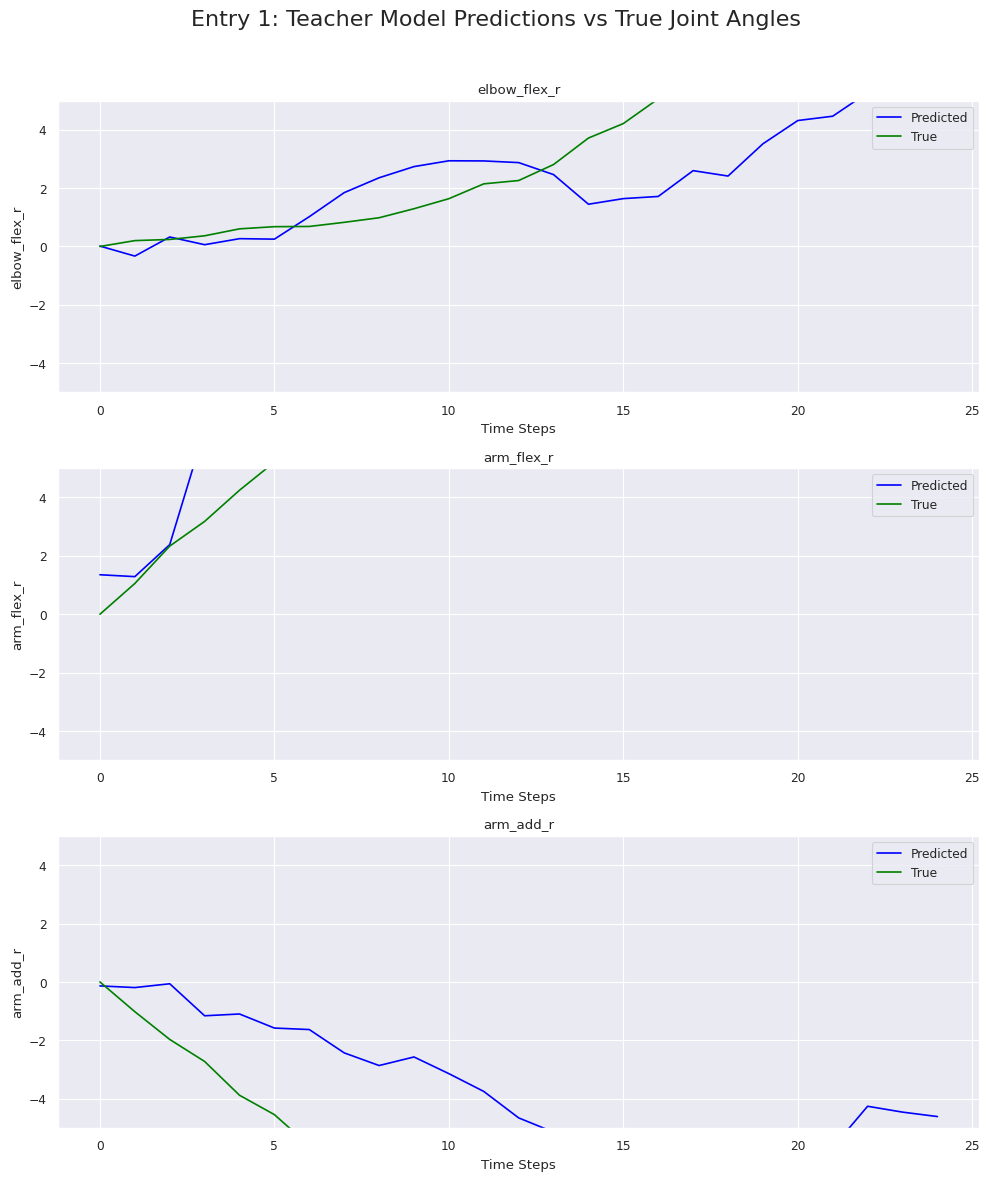

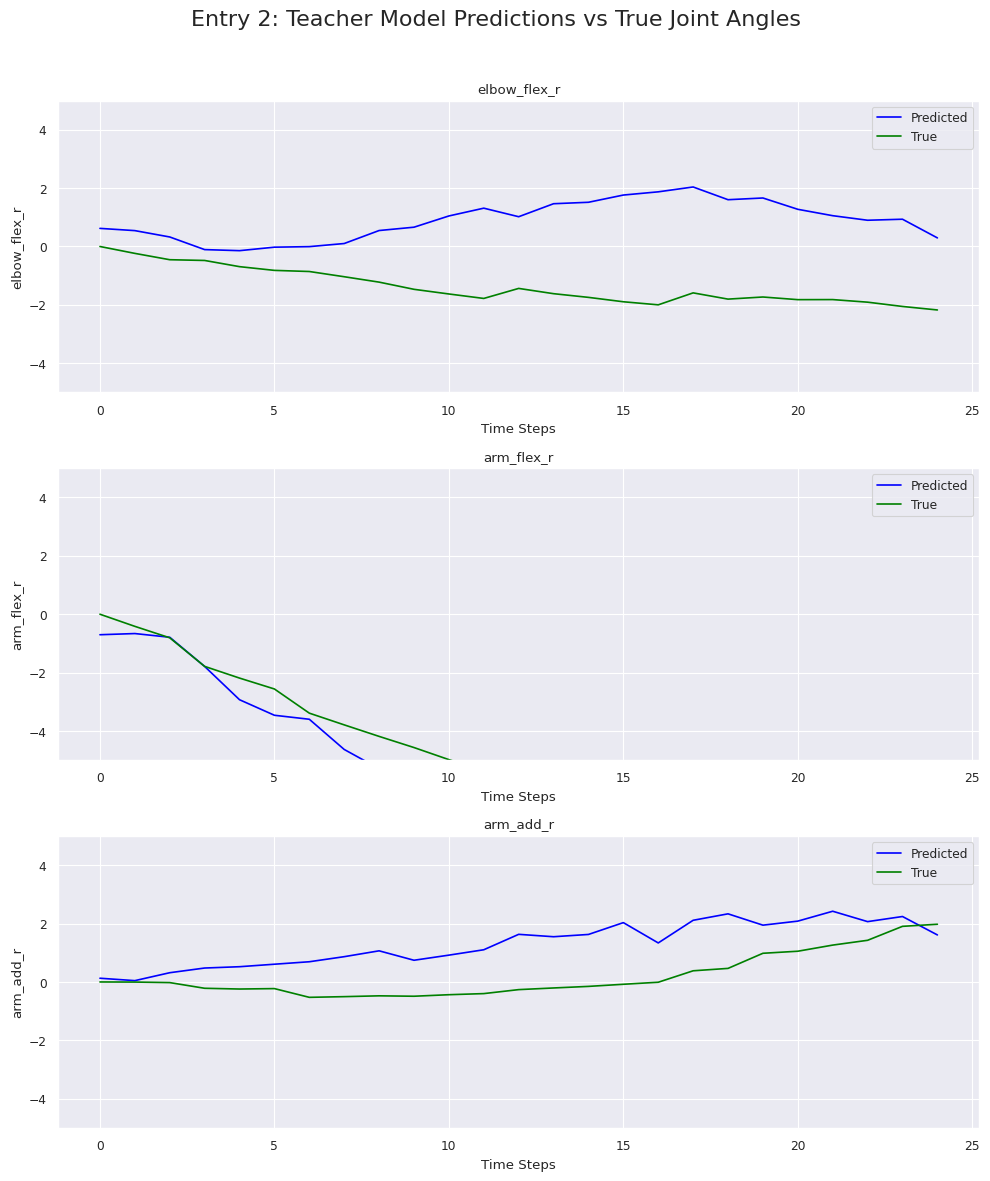

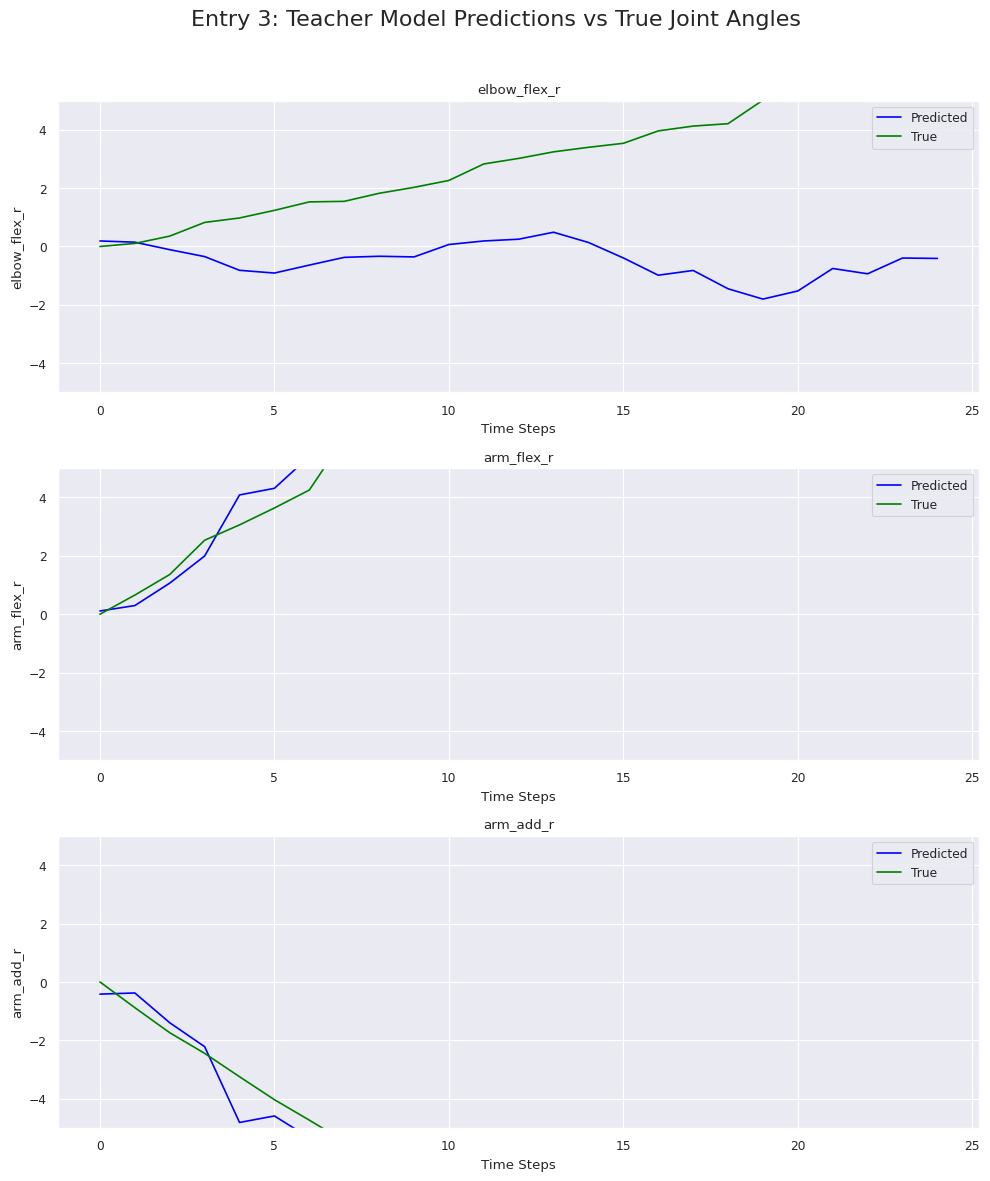

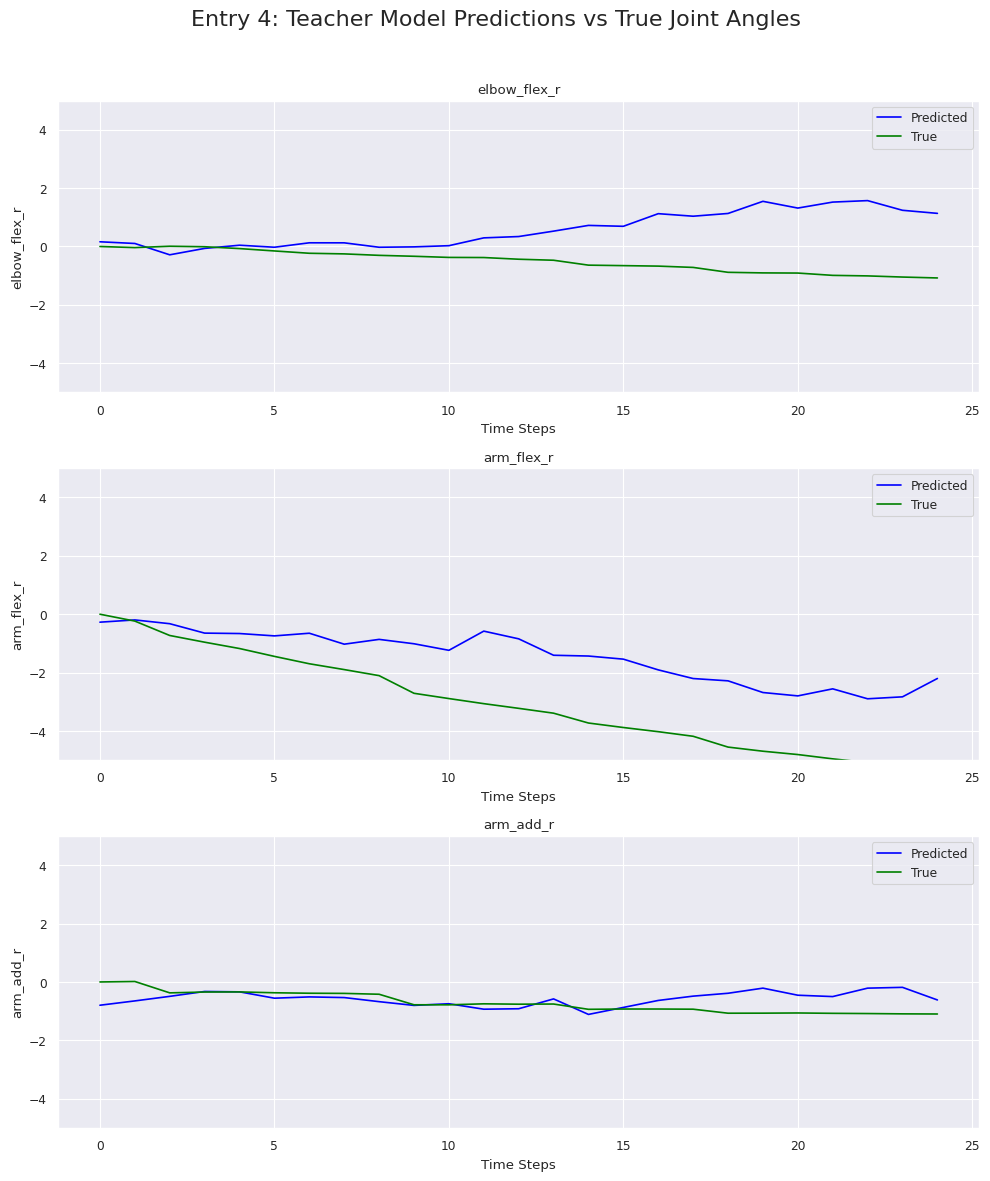

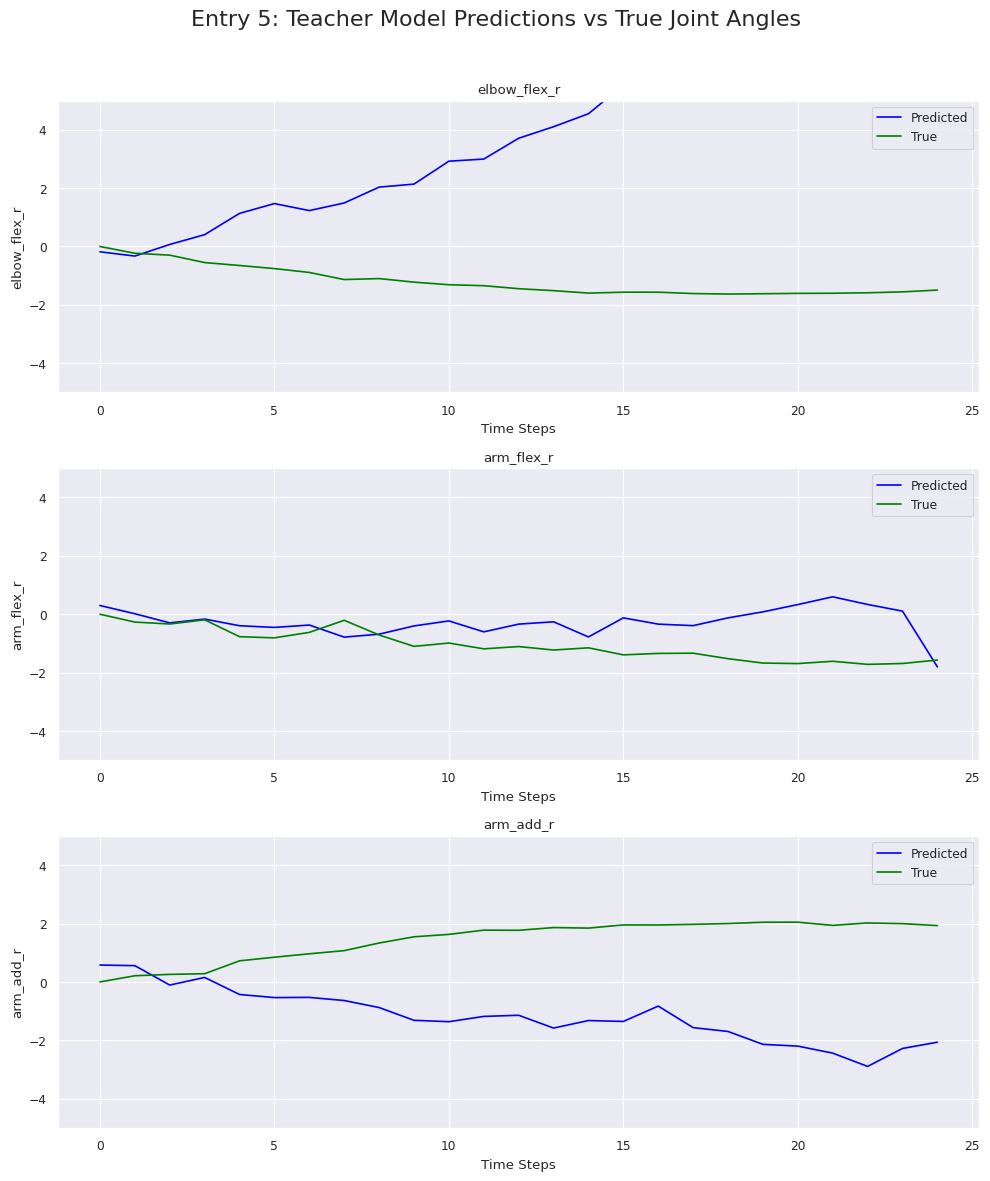

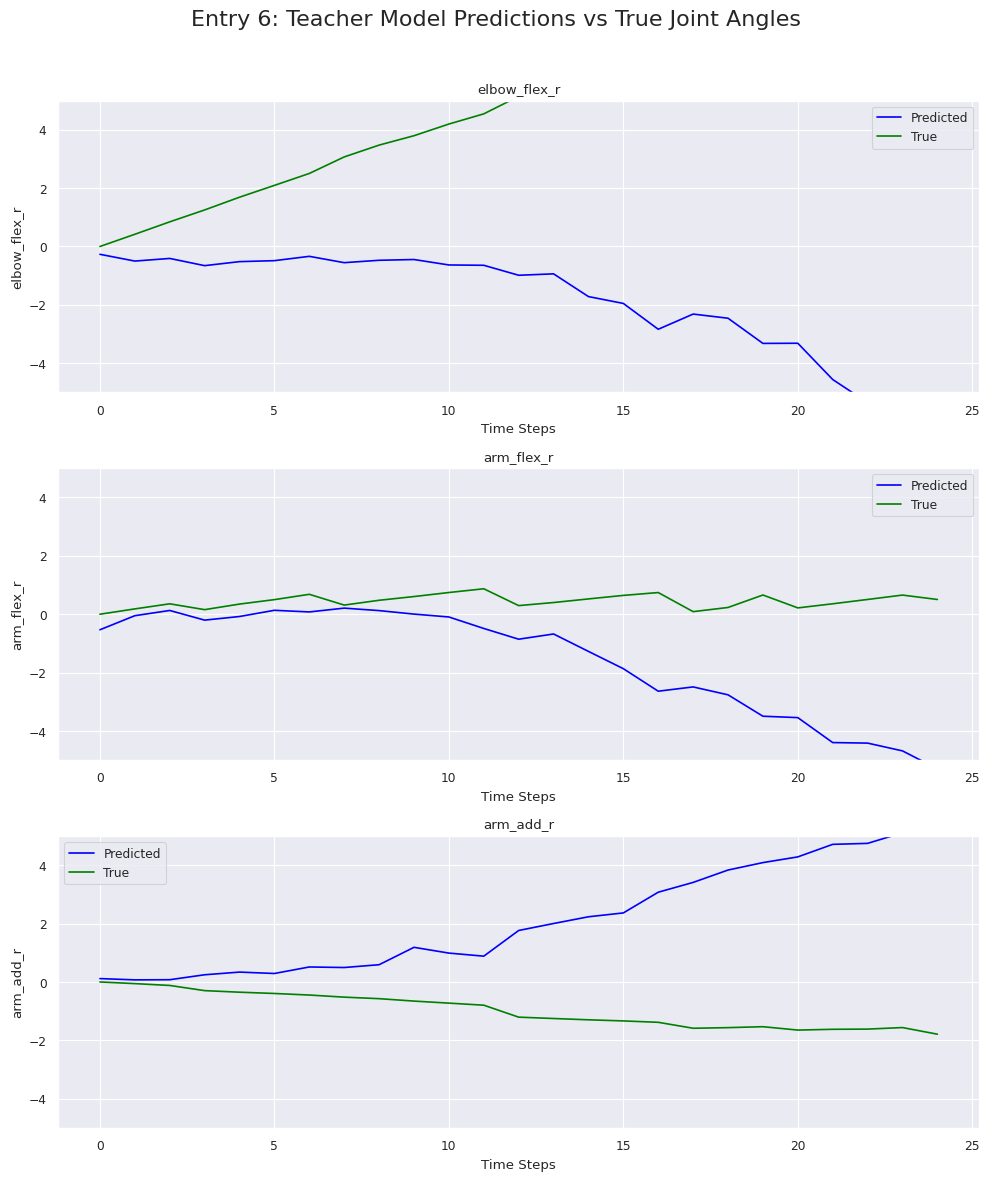

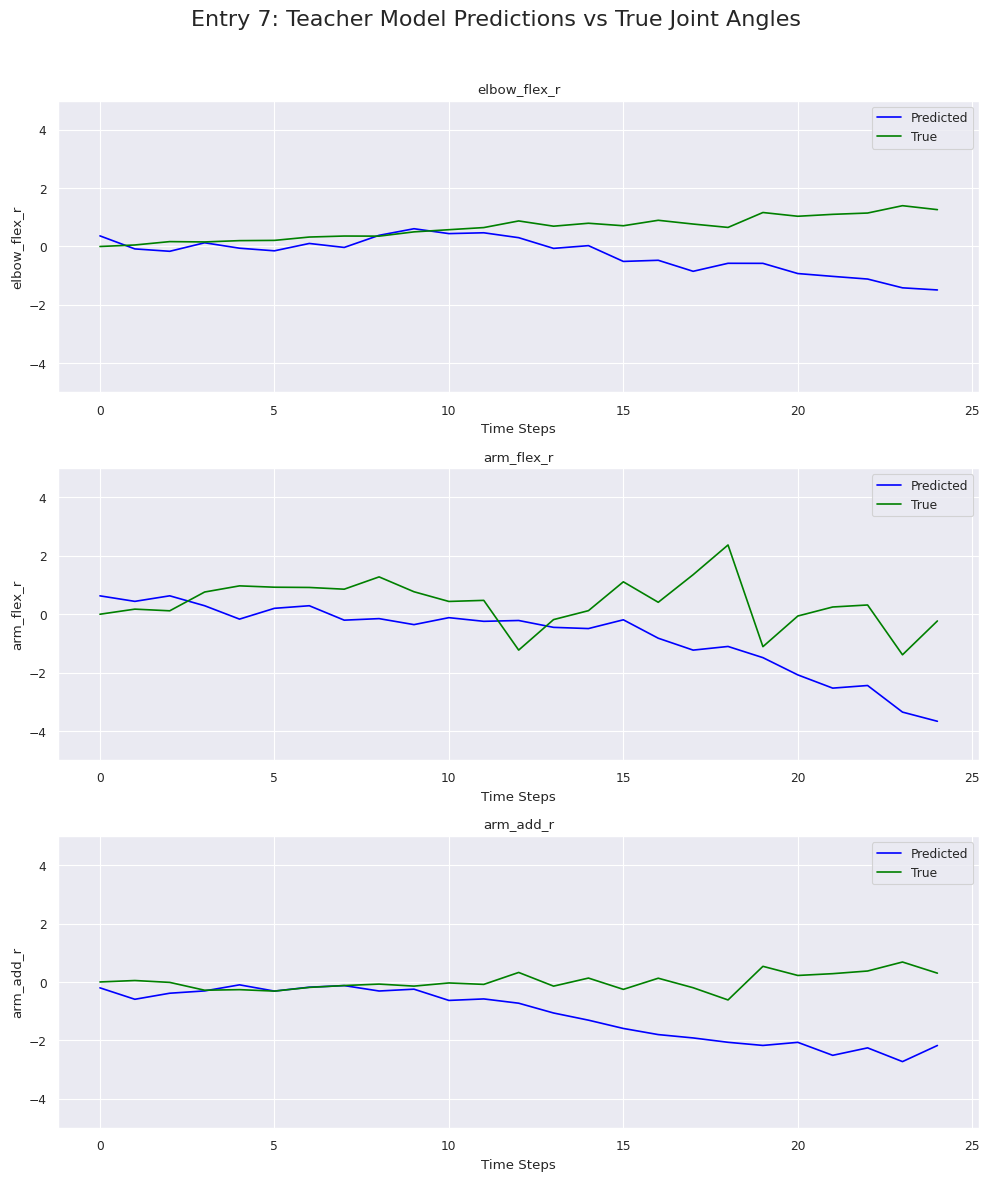

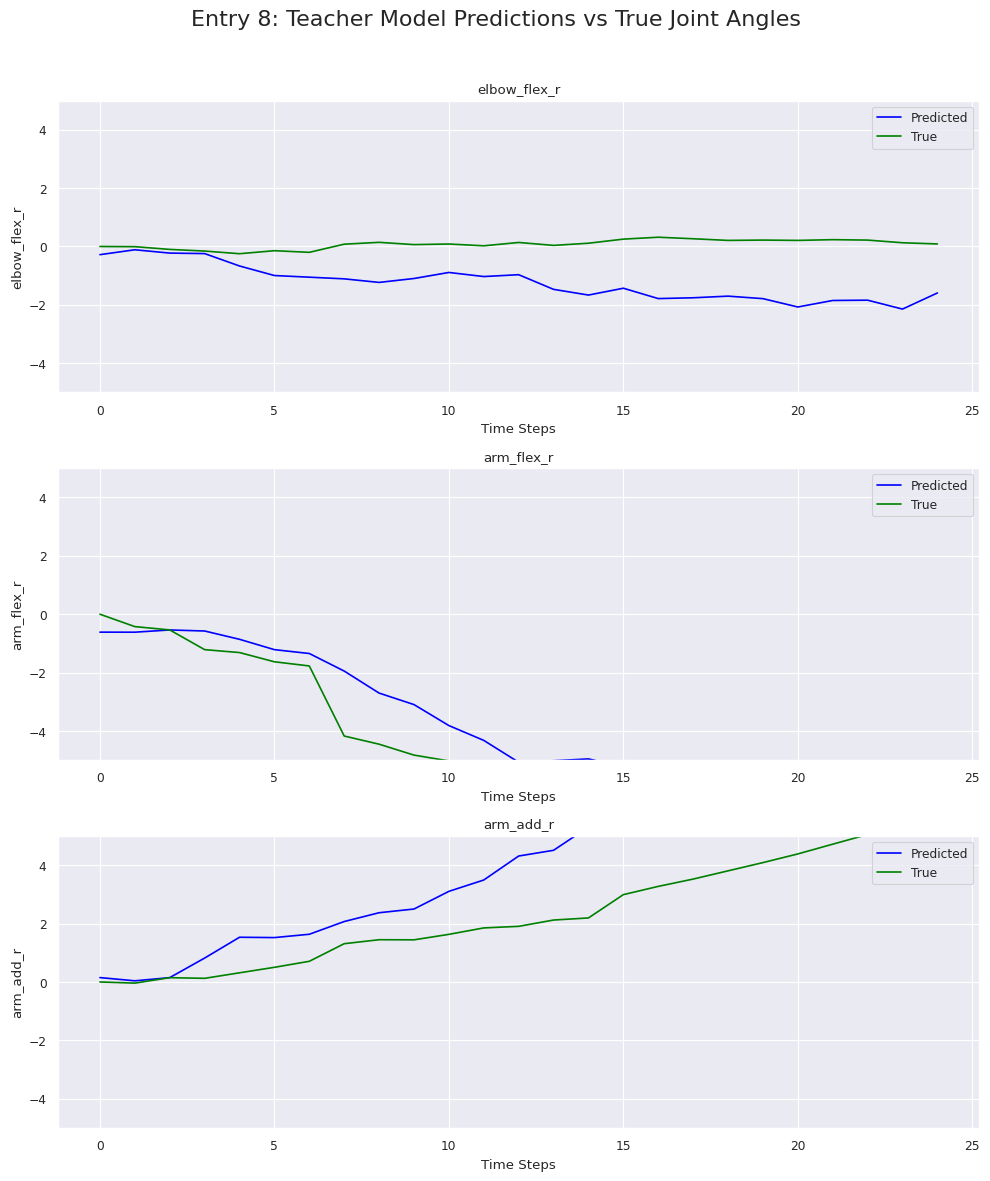

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

train_loader, val_loader, test_loader = create_forecasting_data_loaders(
    config=config,
    train_subjects=[f'subject_{x}' for x in range(2, 14)],
    test_subjects=['subject_1'],
    window_length=100,
    forecast_horizon=25,
    batch_size=64
)

teacher_model = teacher(input_acc=18, input_gyr=18, input_emg=3,
                        drop_prob=0.25, w=100, forecast_horizon=25)
teacher_model.load_state_dict(torch.load('best_teacher_model_subject_subject_1.pth'))

n_entries_to_plot = 20

global_min, global_max = -5, 5


for idx, (x_acc, x_gyr, x_emg, targets) in enumerate(test_loader):
    if idx >= n_entries_to_plot:
        break

    with torch.no_grad():
        predictions = teacher_model(x_acc, x_gyr, x_emg)[0]

    predictions = predictions.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    num_channels = predictions.shape[2]

    fig, axes = plt.subplots(num_channels, 1, figsize=(10, 4 * num_channels))

    fig.suptitle(f'Entry {idx + 1}: Teacher Model Predictions vs True Joint Angles', fontsize=16)

    for i in range(num_channels):

        axes[i].plot(predictions[0, :, i], label='Predicted', color='blue')
        axes[i].plot(targets[0, :, i], label='True', color='green')

        axes[i].set_ylim([-5, 5])

        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel(f'{config.channels_joints[i]}')  # Channel name from config
        axes[i].set_title(f'{config.channels_joints[i]}')
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()